In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt
import matplotlib as mpl


In [3]:
mpl.rcParams['figure.figsize'] = (20, 6)  # Width, Height in inches

In [4]:
file_name = "PGMs_Prices_V3.xlsx"
cols = ['Date', 'Portfolio_Return', 'Portfolio_Value']

df = pd.read_excel(file_name)

df['Date'] = pd.to_datetime(df['Date'])
# Convert timestamps to Unix timestamps (seconds since epoch)
df['UnixTs'] = df['Date'].astype('int64') // 10**9  # Convert nanoseconds to seconds


In [5]:
# also create moving average line

# Calculate the moving average
# df['5DayMA'] = df['Portfolio_Value'].rolling(window=sequence_length).mean()
# df['10DayMA'] = df['Portfolio_Value'].rolling(window=sequence_length * 2).mean()
# df['30DayMA'] = df['Portfolio_Value'].rolling(window=sequence_length * 6).mean()

In [6]:
# normalize data
# df.drop(columns=['Date'], inplace=True)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns

# Calculate original means and standard deviations before normalization
original_means = df[numeric_columns].mean()
original_std_devs = df[numeric_columns].std()


normalized_data = (df[numeric_columns] - original_means) / original_std_devs


In [7]:
# Windowing: Creating sequences/windows
sequence_length = 5  # which is the rolling window dates
sequences = []
for i in range(len(normalized_data) - sequence_length):
    sequences.append(normalized_data[i:i+sequence_length])
sequences = np.array(sequences)

Text(0.5, 1.0, 'Original Data with Moving Average')

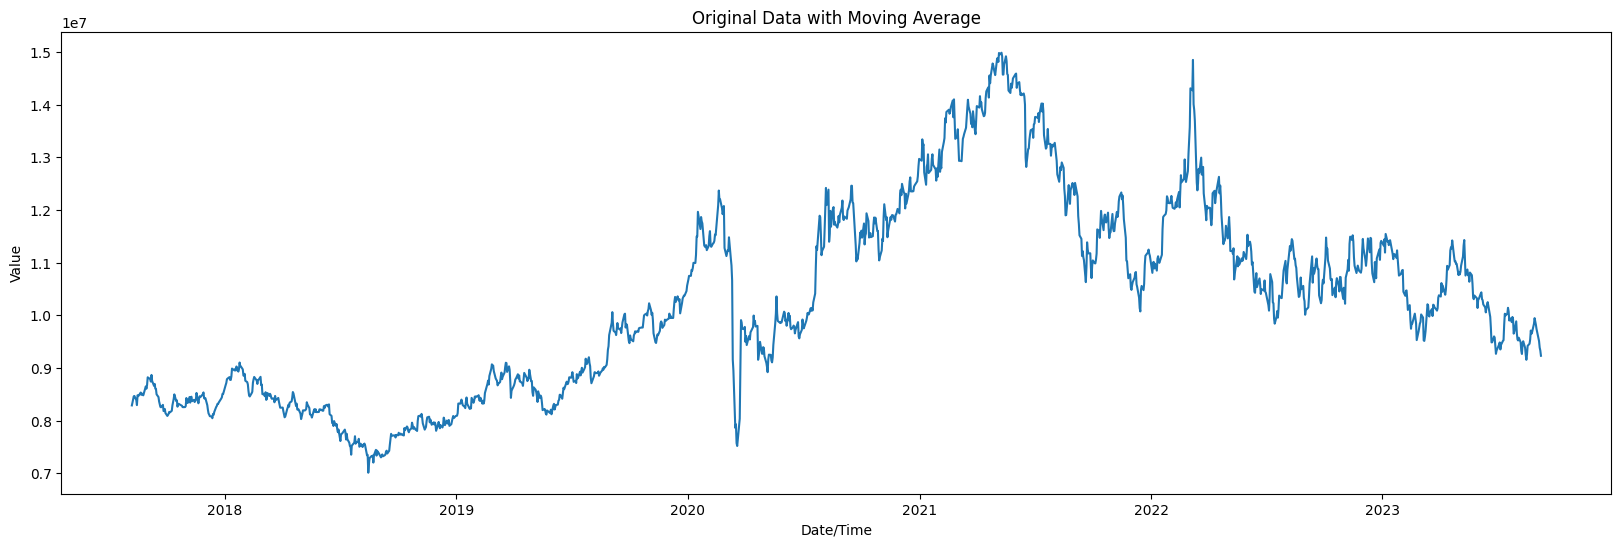

In [8]:
plt.plot(df['Date'], df['Portfolio_Value'], label='Original Data')

# Plot the moving average line
# plt.plot(df['Date'], df['5DayMA'], label='5D MA', lw=0.5, color='cyan')
# plt.plot(df['Date'], df['10DayMA'], label='10D MA', lw=0.5, color='magenta')
# plt.plot(df['Date'], df['30DayMA'], label='30D MA',lw=0.5, color='black')


# Customize labels and title
plt.xlabel('Date/Time')
plt.ylabel('Value')
plt.title('Original Data with Moving Average')

In [9]:
# Split data into train and validation sets
train_size = int(0.8 * len(sequences))
train_data = sequences[:train_size]
val_data = sequences[train_size:]

In [10]:
# Define the autoencoder model
num_features = 33 # ??

model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, num_features), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(num_features))
])

In [11]:
model.compile(optimizer='adam', loss='mse')

# Training the autoencoder
model.fit(train_data, train_data, epochs=100, batch_size=32, validation_data=(val_data, val_data))


Epoch 1/100
39/39 [==============================] - 6s 29ms/step - loss: 0.9113 - val_loss: 0.6552
Epoch 2/100
39/39 [==============================] - 0s 9ms/step - loss: 0.5996 - val_loss: 0.3977
Epoch 3/100
39/39 [==============================] - 0s 9ms/step - loss: 0.4642 - val_loss: 0.3184
Epoch 4/100
39/39 [==============================] - 0s 9ms/step - loss: 0.4116 - val_loss: 0.2871
Epoch 5/100
39/39 [==============================] - 0s 9ms/step - loss: 0.3809 - val_loss: 0.2786
Epoch 6/100
39/39 [==============================] - 0s 10ms/step - loss: 0.3635 - val_loss: 0.2531
Epoch 7/100
39/39 [==============================] - 0s 9ms/step - loss: 0.3494 - val_loss: 0.2342
Epoch 8/100
39/39 [==============================] - 0s 9ms/step - loss: 0.3398 - val_loss: 0.2323
Epoch 9/100
39/39 [==============================] - 0s 8ms/step - loss: 0.3249 - val_loss: 0.2206
Epoch 10/100
39/39 [==============================] - 0s 9ms/step - loss: 0.3147 - val_loss: 0.2110
Epoch 1

In [12]:
# Reconstruction of validation data
predicted_val_data = model.predict(val_data)

# Calculating reconstruction loss
reconstruction_losses = np.mean(np.square(val_data - predicted_val_data), axis=(1, 2))

# Define a threshold for detecting regime changes
# Calculate mean and standard deviation of reconstruction errors on validation set
error_mean = np.mean(reconstruction_losses)
error_std = np.std(reconstruction_losses)

# Set threshold as a multiple of standard deviation above the mean error
#threshold = error_mean + 2 * error_std  # Adjust the multiplier as needed
threshold = error_mean - error_std/8

print(f"error_mean {error_mean}\nerror_std {error_std}\nthreshold {threshold}")

# Detect regime changes based on the threshold for validation dataset
regime_change_indices_val = np.where(reconstruction_losses > threshold)[0]
regime_change_indices_val

# Calculate reconstruction errors for training data
predicted_train_data = model.predict(train_data)
reconstruction_errors_train = np.mean(np.square(train_data - predicted_train_data),  axis=(1, 2))
regime_change_indices_train = np.where(reconstruction_errors_train > threshold)[0]

all_regime_change_indices = np.concatenate((regime_change_indices_train, regime_change_indices_val))

all_regime_change_indices

error_mean 0.13152362350822044
error_std 0.07486450761732283
threshold 0.12216556005605508


array([ 119,  155,  158,  167,  168,  169,  170,  184,  187,  330,  332,
        333,  334,  335,  337,  341,  342,  343,  344,  359,  361,  362,
        363,  364,  369,  370,  371,  372,  373,  381,  382,  383,  384,
        385,  444,  479,  558,  559,  614,  620,  621,  639,  640,  641,
        642,  643,  644,  645,  650,  652,  653,  654,  655,  656,  657,
        670,  671,  672,  673,  674,  677,  678,  679,  680,  681,  682,
        685,  689,  690,  691,  692,  695,  696,  697,  698,  707,  708,
        709,  739,  740,  741,  747,  754,  755,  756,  757,  767,  769,
        770,  775,  780,  783,  784,  786,  792,  793,  794,  813,  831,
        843,  854,  855,  856,  857,  858,  864,  866,  871,  874,  875,
        880,  883, 1031, 1032, 1033,   48,   49,   50,   51,   52,   67,
         68,   69,   70,   71,   73,   75,   78,   79,   80,   81,   82,
         83,   90,   91,   92,   94,  129,  130,  137,  150,  164,  166,
        167,  168,  169,  170,  171,  172,  173,  1

In [13]:
predict_portfolio = np.concatenate([predicted_train_data, predicted_val_data], axis=0)
# s = np.append(predict_portfolio, np.full(sequence_length, predict_portfolio[-1]))
# df_pred = df.assign(New_Column=s)

# # Get the shape of the NumPy array
# num_rows, temp, num_cols = predict_portfolio.shape

# Reshape the 3D array to 2D, dropping the middle dimension
reshaped_data = predict_portfolio.reshape(-1, predict_portfolio.shape[-1])

# Convert the 2D NumPy array to a DataFrame
df_pred = pd.DataFrame(reshaped_data)
print(numeric_columns)
df_pred.columns = numeric_columns

# print(df_pred.head())  # Displaying the first few rows for verification
print(df_pred.columns)



['Portfolio_Return', 'Portfolio_Value', 'AU_Return', 'AG_Return', 'PT_Return', 'PD_Return', 'AU_PX_LAST', 'AG_PX_LAST', 'PT_PX_LAST', 'PD_PX_LAST', 'AU_PX_OPEN', 'AU_PX_LOW', 'AU_PX_HIGH', 'AG_PX_OPEN', 'AG_PX_LOW', 'AG_PX_HIGH', 'PT_PX_OPEN', 'PT_PX_LOW', 'PT_PX_HIGH', 'PD_PX_OPEN', 'PD_PX_LOW', 'AU_INTRA_HL', 'AG_INTRA_HL', 'PT_INTRA_HL', 'AU_INTRA_OC', 'AG_INTRA_OC', 'PT_INTRA_OC', 'PD_INTRA_OC', 'ICE Libor 1M PX_Last', 'ICE Libor 3M PX_Last', 'China Core CPI', 'US CPI Urban Consumer Index', 'UnixTs']
Index(['Portfolio_Return', 'Portfolio_Value', 'AU_Return', 'AG_Return',
       'PT_Return', 'PD_Return', 'AU_PX_LAST', 'AG_PX_LAST', 'PT_PX_LAST',
       'PD_PX_LAST', 'AU_PX_OPEN', 'AU_PX_LOW', 'AU_PX_HIGH', 'AG_PX_OPEN',
       'AG_PX_LOW', 'AG_PX_HIGH', 'PT_PX_OPEN', 'PT_PX_LOW', 'PT_PX_HIGH',
       'PD_PX_OPEN', 'PD_PX_LOW', 'AU_INTRA_HL', 'AG_INTRA_HL', 'PT_INTRA_HL',
       'AU_INTRA_OC', 'AG_INTRA_OC', 'PT_INTRA_OC', 'PD_INTRA_OC',
       'ICE Libor 1M PX_Last', 'ICE Libor 3M P

In [14]:
denormalized_predictions = df_pred * original_std_devs + original_means
denormalized_predictions['Date'] = pd.to_datetime(denormalized_predictions['UnixTs'], unit='s')  # 's' for seconds, 'ms' for milliseconds

print(denormalized_predictions.head)

<bound method NDFrame.head of       Portfolio_Return  Portfolio_Value  AU_Return  AG_Return  PT_Return  \
0            -0.012453     9.248864e+06  -0.000583  -0.005410  -0.016268   
1            -0.008465     9.372933e+06  -0.004070  -0.007241  -0.011722   
2            -0.012331     9.504485e+06  -0.006470  -0.013619  -0.016594   
3            -0.021860     9.615352e+06  -0.025768  -0.028469  -0.026121   
4            -0.003899     9.799163e+06  -0.010385  -0.008446  -0.006875   
...                ...              ...        ...        ...        ...   
7635         -0.024980     8.891483e+06   0.000418  -0.014373  -0.030459   
7636          0.005246     8.944475e+06   0.013450   0.016713   0.008440   
7637          0.007177     9.143434e+06  -0.007110   0.003408   0.002745   
7638          0.009445     9.195013e+06   0.004439   0.008226   0.008168   
7639         -0.002182     8.968794e+06   0.002945  -0.000672  -0.004503   

      PD_Return  AU_PX_LAST  AG_PX_LAST  PT_PX_LAST   PD_

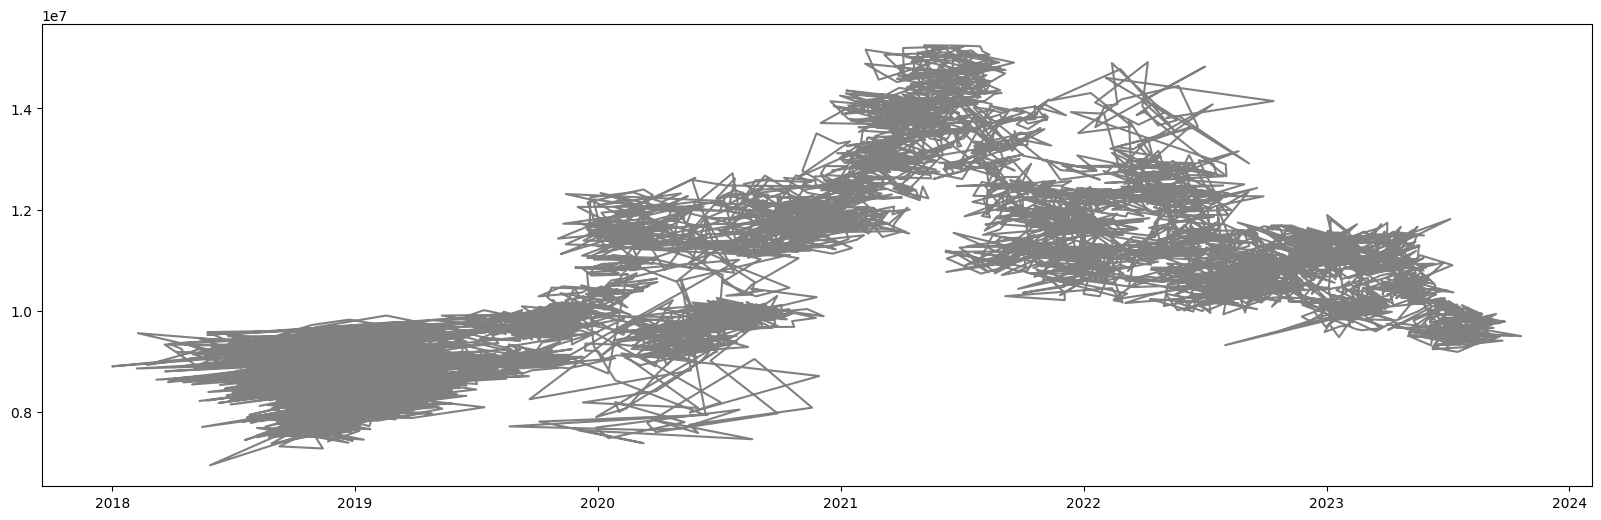

In [15]:
# Plot the data and change points
#plt.plot(df['Date'], df['Portfolio_Value'], label='Portfolio_Value', color="orange")
plt.plot(denormalized_predictions['Date'], denormalized_predictions['Portfolio_Value'], label='Portfolio_Value_Pred', color="gray")

In [16]:
# group change points
from sklearn.cluster import DBSCAN
# Reshape the data for DBSCAN (needed for sklearn)
X = all_regime_change_indices.reshape(-1, 1)

# DBSCAN parameters
epsilon = sequence_length * 2 # Maximum distance between points to be considered in the same neighborhood
min_samples = sequence_length  # Minimum number of samples in a neighborhood

In [17]:
# DBSCAN clustering
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(X)

# Getting cluster labels and core sample indices
cluster_labels = dbscan.labels_
core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

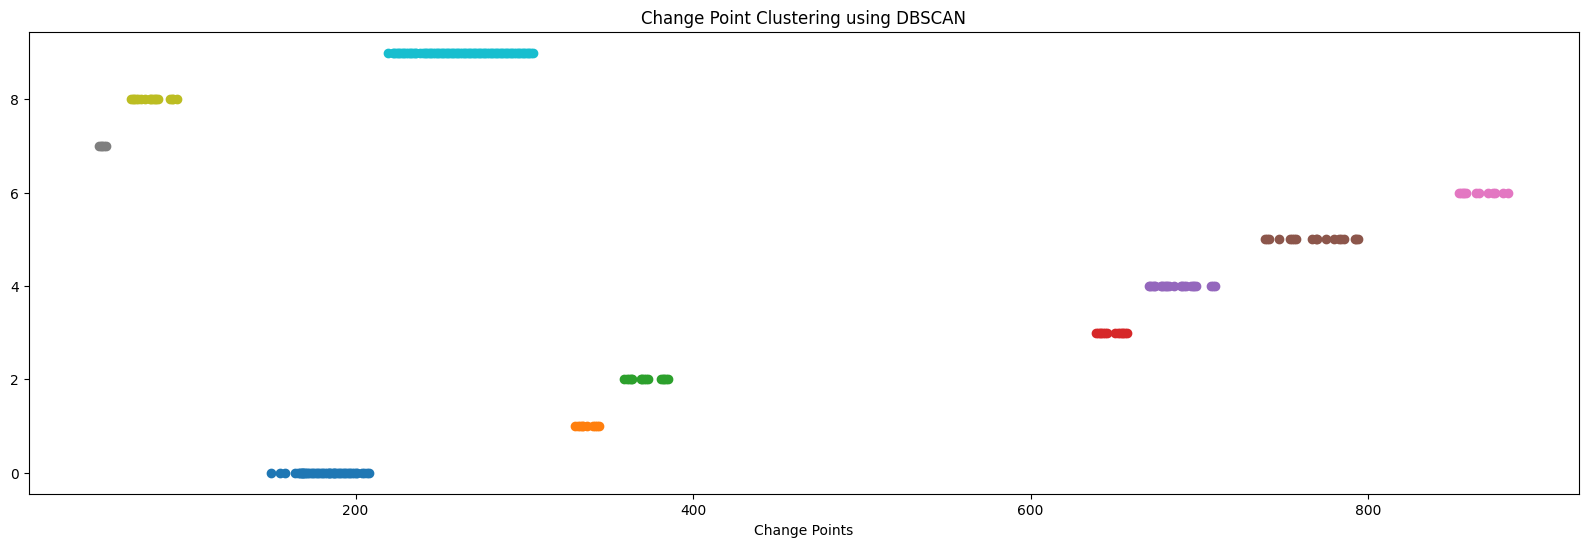

Cluster 0: Change Points - [array([155, 158, 167, 168, 169, 170, 184, 187, 150, 164, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181,
       182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 204, 205, 207, 208], dtype=int64)]
Cluster 1: Change Points - [array([330, 332, 333, 334, 335, 337, 341, 342, 343, 344], dtype=int64)]
Cluster 2: Change Points - [array([359, 361, 362, 363, 364, 369, 370, 371, 372, 373, 381, 382, 383,
       384, 385], dtype=int64)]
Cluster 3: Change Points - [array([639, 640, 641, 642, 643, 644, 645, 650, 652, 653, 654, 655, 656,
       657], dtype=int64)]
Cluster 4: Change Points - [array([670, 671, 672, 673, 674, 677, 678, 679, 680, 681, 682, 685, 689,
       690, 691, 692, 695, 696, 697, 698, 707, 708, 709], dtype=int64)]
Cluster 5: Change Points - [array([739, 740, 741, 747, 754, 755, 756, 757, 767, 769, 770, 775, 780,
       783, 784, 786, 792, 793, 794], dtype=int6

In [18]:
from collections import defaultdict

# Extracting unique clusters and their indices
unique_labels = set(cluster_labels)
cluster_change_points = defaultdict(list)

if -1 in unique_labels:
    unique_labels.remove(-1)  # Remove noise label (-1)


for label in unique_labels:
    cluster_indices = np.where(cluster_labels == label)[0]
    cluster_points = all_regime_change_indices[cluster_indices]
    cluster_change_points[label].append(cluster_points)
    plt.plot(cluster_points, np.ones_like(cluster_points) * label, 'o', label=f'Cluster {label}')

plt.xlabel('Change Points')
plt.title('Change Point Clustering using DBSCAN')
# plt.legend()
plt.show()

# Print or process cluster-wise change points
for cluster, points in cluster_change_points.items():
    print(f"Cluster {cluster}: Change Points - {points}")

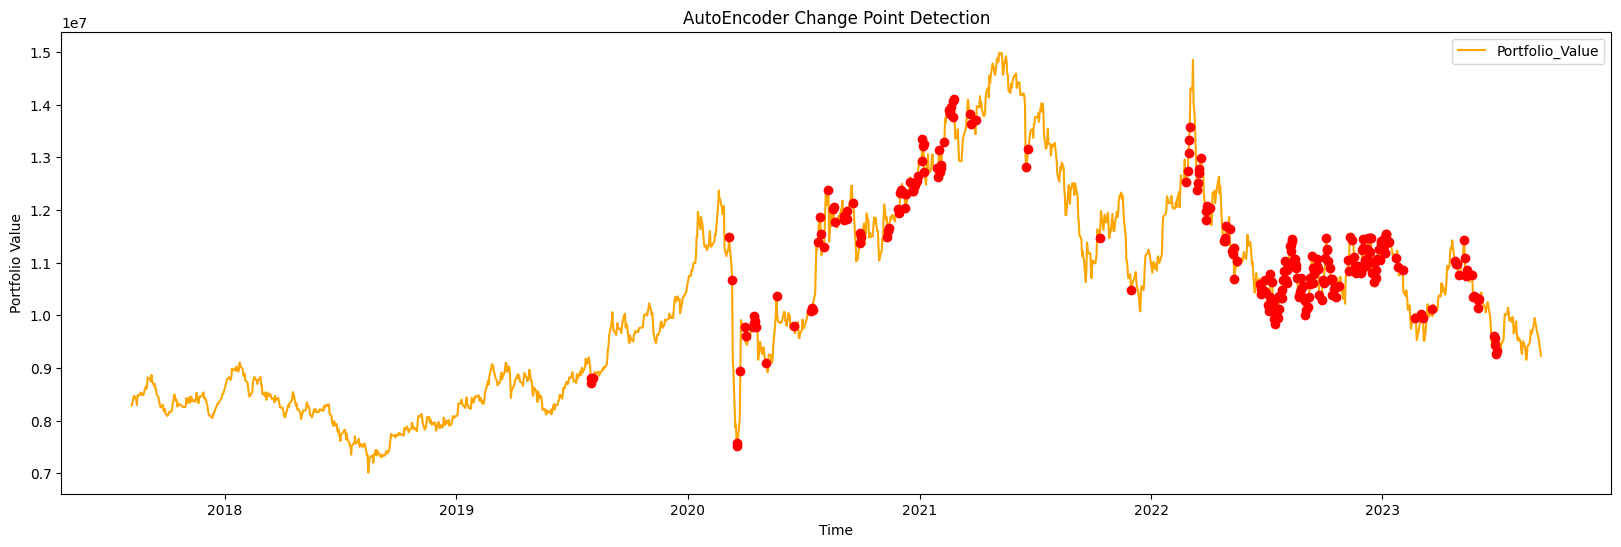

Change points detected at indices: [ 119  155  158  167  168  169  170  184  187  330  332  333  334  335
  337  341  342  343  344  359  361  362  363  364  369  370  371  372
  373  381  382  383  384  385  444  479  558  559  614  620  621  639
  640  641  642  643  644  645  650  652  653  654  655  656  657  670
  671  672  673  674  677  678  679  680  681  682  685  689  690  691
  692  695  696  697  698  707  708  709  739  740  741  747  754  755
  756  757  767  769  770  775  780  783  784  786  792  793  794  813
  831  843  854  855  856  857  858  864  866  871  874  875  880  883
 1031 1032 1033   48   49   50   51   52   67   68   69   70   71   73
   75   78   79   80   81   82   83   90   91   92   94  129  130  137
  150  164  166  167  168  169  170  171  172  173  174  175  176  177
  178  179  180  181  182  183  184  185  186  187  188  189  190  191
  192  193  194  195  196  197  198  199  200  201  204  205  207  208
  219  222  223  224  225  226  227  228  

In [19]:
# Plot the data and change points
plt.plot(df['Date'], df['Portfolio_Value'], label='Portfolio_Value', color="orange")
#plt.scatter(df['Date'], [df['Volatility'][i] for i in change_points], color='red', marker='o', label='Change Points')
#plt.plot(denormalized_predictions['Date'], denormalized_predictions['Portfolio_Value'], label='Portfolio_Value_Pred', color="gray")


# Mark the change points on the chart
for change_point in all_regime_change_indices:
    plt.scatter(df['Date'][change_point], df['Portfolio_Value'][change_point], marker='o', color='red', zorder=3)

# for label in unique_labels:
#     label_indices = np.where(cluster_labels == label)[0]
#     # cluster_points = all_regime_change_indices[label_indices]
#     start_index = label_indices[0]
#     end_index = label_indices[-1]

#     plt.fill_between(df['Date'][start_index:end_index+2], df['Portfolio_Value'][start_index:end_index+2], alpha=0.6, label=f'Cluster {label}')

for cluster, points in cluster_change_points.items():
    # cluster_label = f"Cluster {cluster}"
    index_range = points[0]

    start_index = index_range[0]
    end_index = index_range[len(index_range) -1]

    # plt.fill_between(df['Date'][start_index:end_index+1], df['Portfolio_Value'][start_index:end_index+1], alpha=0.6)

plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.title('AutoEncoder Change Point Detection')
plt.legend()
plt.show()

print("Change points detected at indices:", all_regime_change_indices)

In [ ]:
# Overlaying clustered change points on the original chart
for label in unique_labels:
    cluster_indices = np.where(cluster_labels == label)[0]
    cluster_points = all_regime_change_indices[cluster_indices]
    plt.plot(cluster_points, np.sin(cluster_points), 'o', label=f'Cluster {label}')


In [ ]:
# with change points, define regimes
from sklearn.cluster import KMeans

# Assuming data is your entire dataset and regimes represent the identified change points
# Perform clustering on the data around change points to define regimes
#df.drop(columns=['Date'], axis=1, inplace=True)
cluster_model = KMeans(n_clusters=3)  # Define the number of regimes
cluster_labels = cluster_model.fit_predict(df.iloc[all_regime_change_indices])

cluster_labels

# regimes = []

# for i, label in enumerate(cluster_labels):
#     regime_window = df.iloc[all_regime_change_indices[i]:all_regime_change_indices[i+1]]
#     regimes.append({
#         'Regime': f'Regime_{label}',
#         'Data': regime_window
#     })


TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [ ]:
regimes = []

# Assuming 'data' is your DataFrame and 'all_regime_change_indices' contains change points
for i in range(len(all_regime_change_indices)):
    start_index = all_regime_change_indices[i]
    if i == len(all_regime_change_indices) - 1:
        end_index = len(df) - 1  # Use the last index of the data as the end index for the last regime
    else:
        end_index = all_regime_change_indices[i + 1]

    regime_window = df.iloc[start_index:end_index]
    regimes.append({
        'Regime': f'Regime_{i + 1}',
        'Start_Index': start_index,
        'End_Index': end_index,
        'Data': regime_window
    })

#regimes

In [ ]:
# add back date column for plotting
df['Date'] = pd.to_datetime(df['UnixTs'], unit='s')


Text(0.5, 1.0, 'Original Data with Regime Overlay')

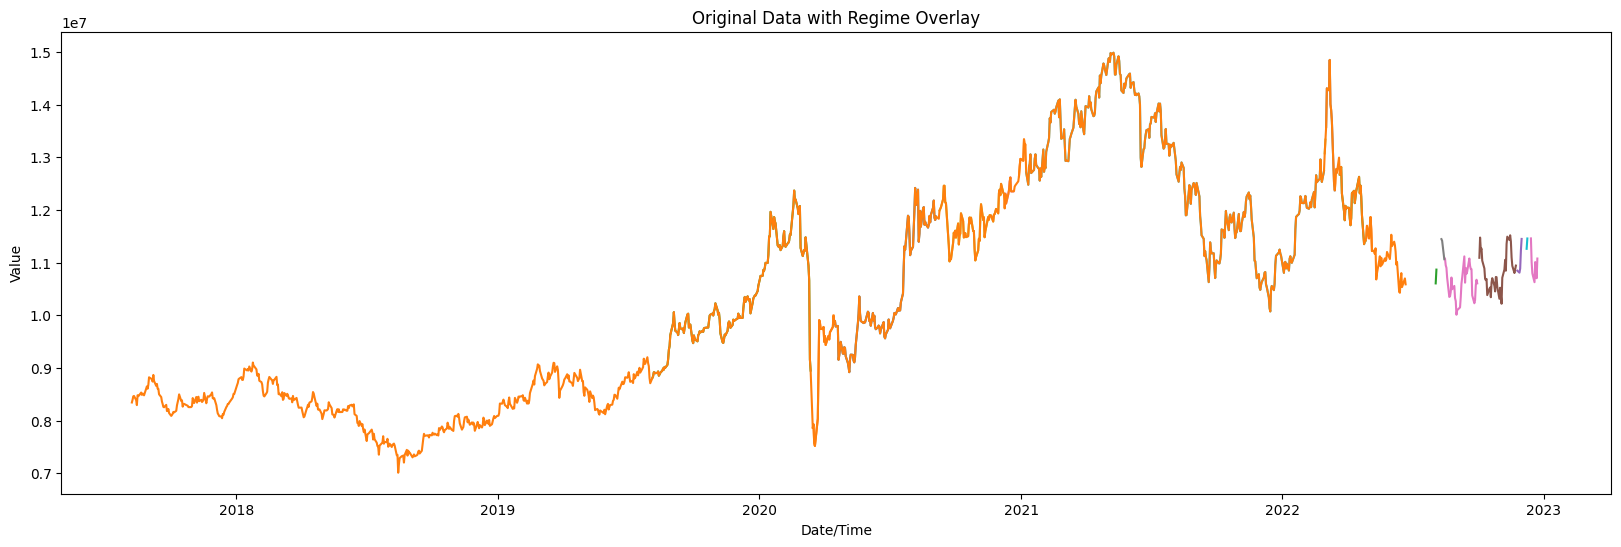

In [ ]:
# Overlay regimes on the chart
for regime in regimes:
    start_index = regime['Start_Index']
    end_index = regime['End_Index']
    regime_data = df.iloc[start_index:end_index]

    plt.plot(regime_data['Date'], regime_data['Portfolio_Value'])

# Customize labels and title
plt.xlabel('Date/Time')
plt.ylabel('Value')
plt.title('Original Data with Regime Overlay')

# Show legend
# plt.legend()


In [ ]:
# plot the moving average



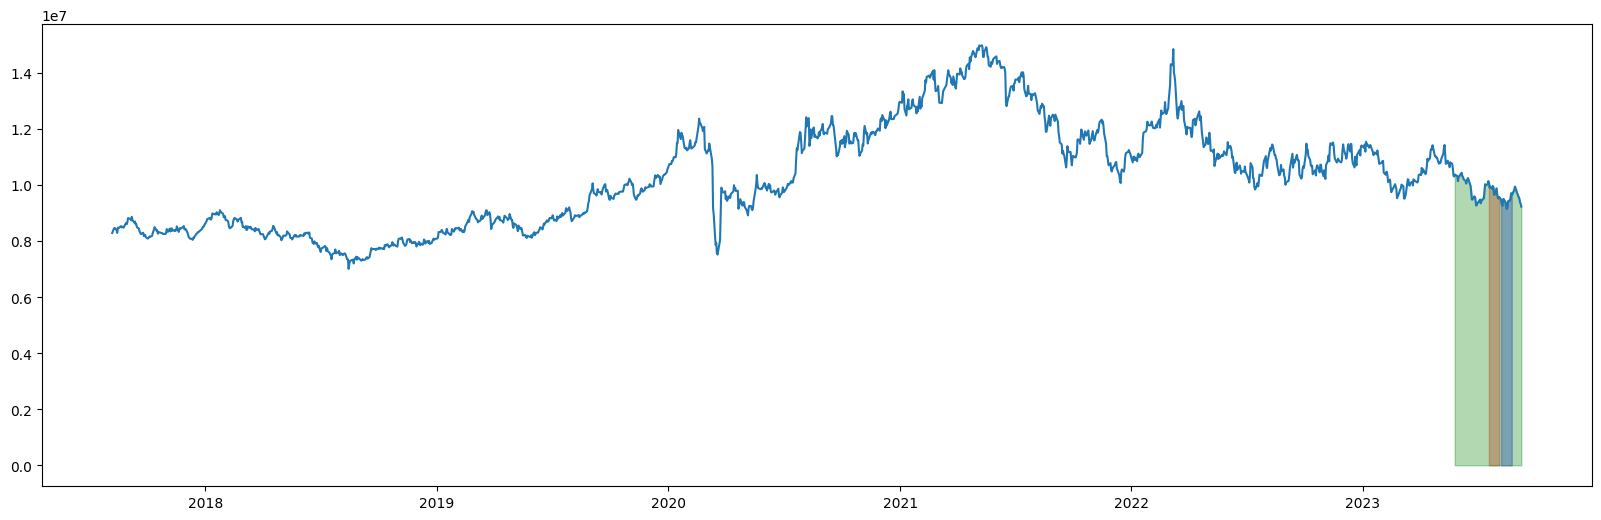

In [ ]:
# Define colors for each label
colors = {0: 'red', 1: 'blue', 2: 'green'}  # Add more colors if needed
# Plot the entire time series data
plt.plot(df['Date'], df['Portfolio_Value'], label='Original Data')

# Highlight regions based on labels
for label in range(3):
    label_indices = np.where(cluster_labels == label)[0]
    if len(label_indices) > 0:
        start_index = label_indices[0]
        end_index = label_indices[-1]
        plt.fill_between(df['Date'].iloc[start_index:end_index + 1],
                         df['Portfolio_Value'].iloc[start_index:end_index + 1],
                         color=colors[label], alpha=0.3, label=f'Label {label}')
